In [1]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
# from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer



# 1. EDA and Preprocessing

In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header =None)

In [3]:
df.head()

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [4]:
df.set_axis(['target', 'ids', 'time', 'query', 'user', 'text'], axis=1, inplace=True)
df.head()

target         ids                          time     query  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   time    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Removing unecessary columns

In [6]:
df['query'].value_counts()

NO_QUERY    1600000
Name: query, dtype: int64

In [7]:
# Only a single value in query. no information contained

df.drop('query', axis=1, inplace=True)

In [8]:
# The two columns are useless for sentiment analysis

df.drop(['ids','time'], axis=1, inplace=True)

In [9]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [10]:
df = df.astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  object
 1   user    1600000 non-null  object
 2   text    1600000 non-null  object
dtypes: object(3)
memory usage: 36.6+ MB


In [11]:
df.describe()

target      user                       text
count   1600000   1600000                    1600000
unique        2    659775                    1581466
top           0  lost_dog  isPlayer Has Died! Sorry 
freq     800000       549                        210

In [12]:
df.user.value_counts()

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
67trinity            1
Sibby                1
mAnyA_15             1
49ersfan111          1
bpbabe               1
Name: user, Length: 659775, dtype: int64

In [13]:
df[df.user == 'lost_dog'].drop('target', axis=1).describe()

user                                               text
count        549                                                549
unique         1                                                549
top     lost_dog  @NyleW I am lost. Please help me find a good h...
freq         549                                                  1

In [14]:
df[df.user == 'lost_dog']

target      user                                               text
43935       0  lost_dog  @NyleW I am lost. Please help me find a good h...
45574       0  lost_dog  @SallyD I am lost. Please help me find a good ...
46919       0  lost_dog  @zuppaholic I am lost. Please help me find a g...
47949       0  lost_dog  @LOSTPETUSA I am lost. Please help me find a g...
50572       0  lost_dog  @JeanLevertHood I am lost. Please help me find...
...       ...       ...                                                ...
792409      0  lost_dog  @trooppetrie I am lost. Please help me find a ...
793314      0  lost_dog  @Carly_FTS I am lost. Please help me find a go...
793610      0  lost_dog  @inathlone I am lost. Please help me find a go...
798608      0  lost_dog  @Kram I am lost. Please help me find a good ho...
799405      0  lost_dog  @W_Hancock I am lost. Please help me find a go...

[549 rows x 3 columns]

In [15]:
df.text[799405]

'@W_Hancock I am lost. Please help me find a good home. '

### Extracting and removing the usernames from text

In [16]:
def extract_ats(text):
    if (isinstance(text,str)==False): 
        print("Error input type should be a string")
        return 0
    
    users = []
    words = text.split()
    sent = []
    for i in range(len(words)):
        if(words[i][0]=='@'):
            users.append(words[i])
        else: sent.append(words[i])
    sent = ' '.join(sent)
    if(len(users) ==0): return ''
    return ','.join(users)

def extract_text(text):
    if (isinstance(text,str)==False): 
        print("Error input type should be a string")
        return 0
    
    users = []
    words = text.split()
    sent = []
    for i in range(len(words)):
        if(words[i][0]=='@'):
            users.append(words[i])
        else: sent.append(words[i])
    sent = ' '.join(sent)
    return sent

In [17]:
extract_ats('My name is subham agarwal. Hi! @sanjeet @arya')

'@sanjeet,@arya'

In [18]:
extract_text('My name is subham agarwal. Hi! @sanjeet @arya')

'My name is subham agarwal. Hi!'

In [19]:
df['receiver'] = df['text'].apply(extract_ats)
df['plain_text'] = df['text'].apply(extract_text)

In [20]:
df[df['user'] =='lost_dog'].describe()

target      user                                               text  \
count      549       549                                                549   
unique       1         1                                                549   
top          0  lost_dog  @NyleW I am lost. Please help me find a good h...   
freq       549       549                                                  1   

       receiver                                   plain_text  
count       549                                          549  
unique      549                                            1  
top      @NyleW  I am lost. Please help me find a good home.  
freq          1                                          549

In [21]:
df.head(10)

target             user                                               text  \
0      0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1      0    scotthamilton  is upset that he can't update his Facebook by ...   
2      0         mattycus  @Kenichan I dived many times for the ball. Man...   
3      0          ElleCTF    my whole body feels itchy and like its on fire    
4      0           Karoli  @nationwideclass no, it's not behaving at all....   
5      0         joy_wolf                      @Kwesidei not the whole crew    
6      0          mybirch                                        Need a hug    
7      0             coZZ  @LOLTrish hey  long time no see! Yes.. Rains a...   
8      0  2Hood4Hollywood               @Tatiana_K nope they didn't have it    
9      0          mimismo                          @twittera que me muera ?    

           receiver                                         plain_text  
0       @switchfoot  http://twitpic.com/2y1zl - Awww, that's a bumm...  
1                    is upset that he can't update his Facebook by ...  
2         @Kenichan  I dived many times for the ball. Managed to sa...  
3                       my whole body feels itchy and like its on fire  
4  @nationwideclass  no, it's not behaving at all. i'm mad. why am ...  
5         @Kwesidei                                 not the whole crew  
6                                                           Need a hug  
7         @LOLTrish  hey long time no see! Yes.. Rains a bit ,only ...  
8        @Tatiana_K                           nope they didn't have it  
9         @twittera                                     que me muera ?

### Grouping by same text-string to remove repetitions between tweets and get a proper dataset

In [22]:
new_df = df.loc[:,['target','plain_text']].groupby(['plain_text']).mean().reset_index()
new_df

plain_text    target
0                                                           1.813275
1                                                        !  2.666667
2        ! ! ! ! You'll love it! Can't wait to see you ...  4.000000
3                                          ! #followfriday  4.000000
4        ! (recruiter): &quot;Community Server / ShareP...  4.000000
...                                                    ...       ...
1551382  ï¿½ï¿½h. iï¿½m gonna go in the &quot;big&quot;...  4.000000
1551383  ï¿½ï¿½ï¿½ After the dishes I've seen you prepa...  4.000000
1551384          ï¿½ï¿½ï¿½ It's my Birthday !!!!!!!!!!!!!!  4.000000
1551385  ï¿½ï¿½ï¿½ hurry so I won't think about jon and...  4.000000
1551386  ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...  4.000000

[1551387 rows x 2 columns]

In [23]:
new_df[new_df['target']%4 >0]

plain_text    target
0                                                           1.813275
1                                                        !  2.666667
98                                                     !!!  1.000000
714                                               #Canucks  2.000000
730      #Chuck: Renewed! Rumored to be heading to Frid...  2.000000
...                                                    ...       ...
1549684                                                  ~  2.000000
1549761  ~ My Monday ROCKED! Thanks for asking! AND yes...  2.000000
1549814  ~ What happened to your tweeter ? Did you lose...  2.000000
1550066  ~~~X0X0~~~!!!X0X0!!! I love you!!! &amp; I mis...  2.000000
1550998                                                â¥  2.000000

[3196 rows x 2 columns]

In [24]:
def roundto4(val):
    if(val%2==0): return val
    return (round(val/4)*4)

# this funcion returns values mapping them as:
#     0<= x <2 = 0
#     x == 2   = 2
#     2< x <=4 = 4

In [25]:
new_df['target_new'] = new_df['target'].apply(roundto4)
new_df['target_new'].value_counts()

0.0    777659
4.0    771408
2.0      2320
Name: target_new, dtype: int64

In [26]:
df= new_df[new_df['target_new']%4==0][['plain_text','target_new']]
df.set_axis(['text','target'],axis=1,inplace=True)
df

text  target
0                                                              0.0
1                                                        !     4.0
2        ! ! ! ! You'll love it! Can't wait to see you ...     4.0
3                                          ! #followfriday     4.0
4        ! (recruiter): &quot;Community Server / ShareP...     4.0
...                                                    ...     ...
1551382  ï¿½ï¿½h. iï¿½m gonna go in the &quot;big&quot;...     4.0
1551383  ï¿½ï¿½ï¿½ After the dishes I've seen you prepa...     4.0
1551384          ï¿½ï¿½ï¿½ It's my Birthday !!!!!!!!!!!!!!     4.0
1551385  ï¿½ï¿½ï¿½ hurry so I won't think about jon and...     4.0
1551386  ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...     4.0

[1549067 rows x 2 columns]

In [27]:
df.target.value_counts()

0.0    777659
4.0    771408
Name: target, dtype: int64

## Saving the data to a csv

In [28]:
# df.to_csv("twitter.contracted.csv", index=False)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549067 entries, 0 to 1551386
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1549067 non-null  object 
 1   target  1549067 non-null  float64
dtypes: float64(1), object(1)
memory usage: 35.5+ MB


## Start from here when restarting

In [80]:
df = pd.read_csv("twitter.contracted.csv")
df.dropna(inplace=True)
df.head()

text  target
1                                                  !     4.0
2  ! ! ! ! You'll love it! Can't wait to see you ...     4.0
3                                    ! #followfriday     4.0
4  ! (recruiter): &quot;Community Server / ShareP...     4.0
5  ! . So not paying Â£60 for a good seat to watc...     0.0

In [81]:
alp = df.loc[10469,'text']
alp

'&quot;The Gmail gadget does not support the &quot;Always use https&quot;&quot; grr doofes igoogle will aber kein http nutzen........'

#### The string "\&quot;" appears again and again. need to remove it

In [82]:
def cleaning_quots(text):
    return re.sub('&quot;', '', text).strip()

df['text'] = df['text'].apply(lambda x: cleaning_quots(x))
df['text'].tail(15)

1549052                          ï¿½timo domingo for you too
1549053    ï¿½ts ok. let me know if I post too much thoug...
1549054    ï¿½waiting for the MacBook 13'' Unibody Repair...
1549055        ï¿½work is done. now it's time to play, dude.
1549056    ï¿½www i was at home house til bout 5 then jus...
1549057                 ï¿½ï¿½ why not today, huh? huh? Huh?
1549058    ï¿½ï¿½We are ready for the new generation!!......
1549059                                      ï¿½ï¿½beautiful
1549060    ï¿½ï¿½h remember the titans at english class, ...
1549061               ï¿½ï¿½h, meinte natï¿½rlich knopfknopf
1549062    ï¿½ï¿½h. iï¿½m gonna go in the big house now, ...
1549063    ï¿½ï¿½ï¿½ After the dishes I've seen you prepa...
1549064            ï¿½ï¿½ï¿½ It's my Birthday !!!!!!!!!!!!!!
1549065    ï¿½ï¿½ï¿½ hurry so I won't think about jon and...
1549066    ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...
Name: text, dtype: object

In [83]:
alp = df.loc[10469,'text']
alp

'The Gmail gadget does not support the Always use https grr doofes igoogle will aber kein http nutzen........'

<AxesSubplot:xlabel='target', ylabel='count'>

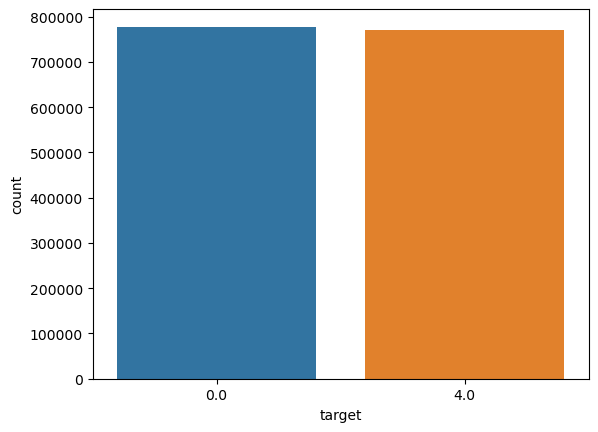

In [84]:
sns.countplot(x='target', data=df)

### Extra- Some exploration on #Hashtags.

In [85]:
def extract_hash(text):
    if (isinstance(text,str)==False): 
        print("Error input type should be a string")
        return 0
    
    tags = []
    words = text.split()
    sent = []
    for i in range(len(words)):
        if(words[i][0]=='#'):
            tags.append(words[i].split('#')[1])
        else: sent.append(words[i])
    sent = ' '.join(sent)
    if(len(tags) ==0): return ''
    return tags

# This function returns hashtags as a list, if they exist

In [86]:
df['hashtags'] = df['text'].apply(extract_hash)
df['hash_len'] = df['hashtags'].apply(len)

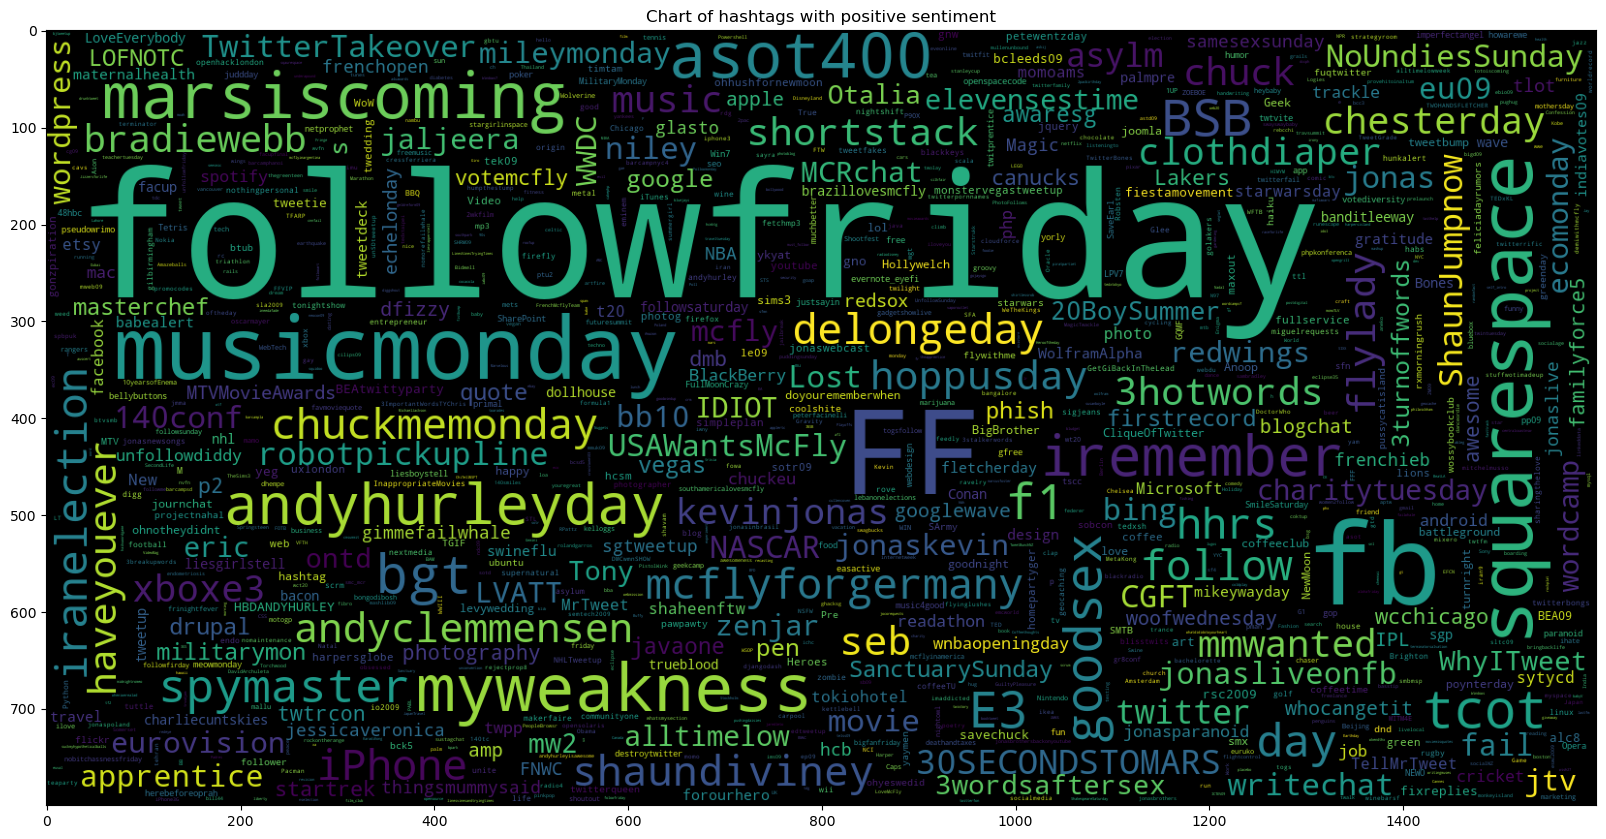

In [87]:
data_pos = df[(df['hash_len']>0) & (df['target']==4)]['hashtags'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))

plt.title('Chart of hashtags with positive sentiment')
plt.imshow(wc)

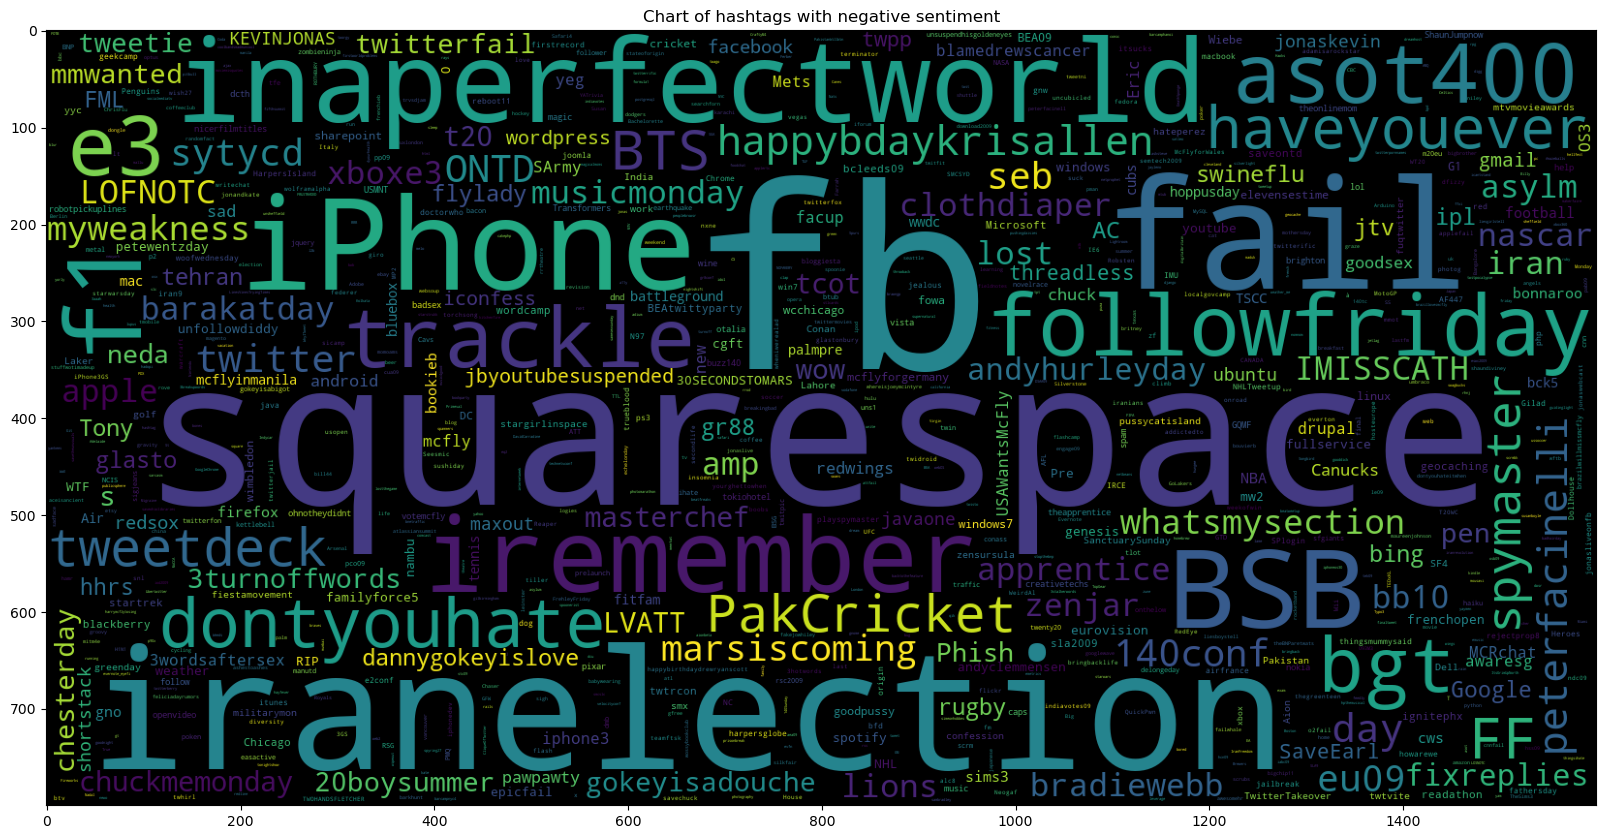

In [88]:
data_neg = df[(df['hash_len']>0) & (df['target']==0)]['hashtags'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_neg))

plt.title('Chart of hashtags with negative sentiment')
plt.imshow(wc)

In [89]:
print(f'Total number of hashtagged tweets are: \n{len(data_pos)} positive tweets and \n{len(data_neg)} negative tweets')
print(f'So about{(len(data_pos)+len(data_neg))*100/len(df): 0.2}% of data has hashtags only')

Total number of hashtagged tweets are: 
19953 positive tweets and 
15132 negative tweets
So about 2.3% of data has hashtags only


Most hashtags are common to both sentiments and also only 2.3% of data has hashtags <br> So #Hashtags are not useful 

In [90]:
df.drop(['hashtags', 'hash_len'], axis=1, inplace=True)

# Preprocessing

In [91]:
df['target'] = df['target'].replace(4,1)

In [92]:
df.target.value_counts()

0.0    777657
1.0    771408
Name: target, dtype: int64

In [93]:
imb = (df.target.value_counts()[0]-df.target.value_counts()[1])/df.target.value_counts()[1]

print(f'Imbalance in data is {imb*100:4.2}%. Data is Balanced!')

Imbalance in data is 0.81%. Data is Balanced!


### Removing repeated chars, URLs, numbers, punctuations and other weird characters


In [94]:
import string

In [95]:
def cleaning_URLs(text):
    cll = re.sub('http\S+','',text)
    cll = re.sub('www\S+','',cll)
    return cll

df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail(15)

1549052                          ï¿½timo domingo for you too
1549053    ï¿½ts ok. let me know if I post too much thoug...
1549054    ï¿½waiting for the MacBook 13'' Unibody Repair...
1549055        ï¿½work is done. now it's time to play, dude.
1549056    ï¿½www i was at home house til bout 5 then jus...
1549057                 ï¿½ï¿½ why not today, huh? huh? Huh?
1549058    ï¿½ï¿½We are ready for the new generation!!......
1549059                                      ï¿½ï¿½beautiful
1549060    ï¿½ï¿½h remember the titans at english class, ...
1549061               ï¿½ï¿½h, meinte natï¿½rlich knopfknopf
1549062    ï¿½ï¿½h. iï¿½m gonna go in the big house now, ...
1549063    ï¿½ï¿½ï¿½ After the dishes I've seen you prepa...
1549064            ï¿½ï¿½ï¿½ It's my Birthday !!!!!!!!!!!!!!
1549065    ï¿½ï¿½ï¿½ hurry so I won't think about jon and...
1549066    ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...
Name: text, dtype: object

In [96]:
def get_decontracted(phrase):
    phrase = str.lower(phrase)
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "am not", phrase)
    phrase = re.sub(r"gonna","going to", phrase)
    phrase = re.sub(r"wanna","want to", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['text'] = df['text'].apply(lambda x: get_decontracted(x))
df['text'].tail(15)

1549052                          ï¿½timo domingo for you too
1549053    ï¿½ts ok. let me know if i post too much thoug...
1549054    ï¿½waiting for the macbook 13'' unibody repair...
1549055       ï¿½work is done. now it is time to play, dude.
1549056    ï¿½www i was at home house til bout 5 then jus...
1549057                 ï¿½ï¿½ why not today, huh? huh? huh?
1549058    ï¿½ï¿½we are ready for the new generation!!......
1549059                                      ï¿½ï¿½beautiful
1549060    ï¿½ï¿½h remember the titans at english class, ...
1549061               ï¿½ï¿½h, meinte natï¿½rlich knopfknopf
1549062    ï¿½ï¿½h. iï¿½m going to go in the big house no...
1549063    ï¿½ï¿½ï¿½ after the dishes i have seen you pre...
1549064           ï¿½ï¿½ï¿½ it is my birthday !!!!!!!!!!!!!!
1549065    ï¿½ï¿½ï¿½ hurry so i will not think about jon ...
1549066    ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½ç¿ï¿½ï¿½ï¿½ï¿½ï¿½ð¶ï¿½øï¿...
Name: text, dtype: object

In [97]:
# Here I am removing all characters which are not part of alphabet

def cleaning_weird_char(text):
    return ''.join(e for e in text if e in string.ascii_letters+' ')

df['text'] = df['text'].apply(lambda x: cleaning_weird_char(x))
df['text'].tail(15)

1549052                             timo domingo for you too
1549053    ts ok let me know if i post too much though id...
1549054       waiting for the macbook  unibody repair guides
1549055             work is done now it is time to play dude
1549056    www i was at home house til bout  then just di...
1549057                            why not today huh huh huh
1549058    we are ready for the new generationoh yeahwe a...
1549059                                            beautiful
1549060    h remember the titans at english class could i...
1549061                         h meinte natrlich knopfknopf
1549062    h im going to go in the big house now borrow m...
1549063     after the dishes i have seen you prepare for ...
1549064                                   it is my birthday 
1549065         hurry so i will not think about jon and kate
1549066     ltlti did not know i cud or how to do all dat...
Name: text, dtype: object

In [98]:
def cleaning_doublespaces(text):
    return re.sub('  ',' ',text).strip()

df['text'] = df['text'].apply(lambda x: cleaning_doublespaces(x))
df['text'].tail(15)

1549052                             timo domingo for you too
1549053    ts ok let me know if i post too much though id...
1549054        waiting for the macbook unibody repair guides
1549055             work is done now it is time to play dude
1549056    www i was at home house til bout then just did...
1549057                            why not today huh huh huh
1549058    we are ready for the new generationoh yeahwe a...
1549059                                            beautiful
1549060    h remember the titans at english class could i...
1549061                         h meinte natrlich knopfknopf
1549062    h im going to go in the big house now borrow m...
1549063    after the dishes i have seen you prepare for y...
1549064                                    it is my birthday
1549065         hurry so i will not think about jon and kate
1549066    ltlti did not know i cud or how to do all dat ...
Name: text, dtype: object

In [99]:
df.dropna(inplace=True)
df= df[df['text']!=''].reset_index(drop=True)

In [100]:
df['text'].head(15)

0     you will love it can not wait to see you at wh...
1                                          followfriday
2     recruiter community server sharepoint dev gig ...
3     so not paying for a good seat to watch miley g...
4     aaahhhhhh i am excited pushi this in home it i...
5                   cool pic amp username ahah whats up
6                          feel better because i say so
7     good morning brad i am ready to empower myself...
8     he has a favourite you are his favourite omgaa...
9                                          hate ben sck
10         half jack is my favourite of all their songs
11    haveing fun kimmii soo funny just been singing...
12                            hope it goes away quickly
13                        how was the land of the scots
14    i almost did a return on palm pre at best buy ...
Name: text, dtype: object

### Removing Stopwords

In [101]:
stopwordlist = pd.read_csv('stopwords.dat', header=None)[0].values

STOPWORDS = set(stopwordlist)

def cleaning_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head(15)

0        love not wait see admin best server ever happy
1                                          followfriday
2     recruiter community server sharepoint dev gig ...
3     not paying good seat watch miley guess bbc swi...
4     aaahhhhhh excited pushi home okay aawww happy ...
5                   cool pic amp username ahah whats up
6                                       feel better say
7     good morning brad ready empower renewed week a...
8     favourite favourite omgaah sorry creepering no...
9                                          hate ben sck
10                            half jack favourite songs
11    haveing fun kimmii soo funny singing lessons x...
12                               hope goes away quickly
13                                           land scots
14    almost return palm pre best buy mobile not goo...
Name: text, dtype: object

In [102]:
df = df[df['text']!='']
# Dropping rows with no data

In [103]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail(15)

1548149                                         timo domingo
1548150    ts ok let know post much though id rather tld ...
1548151                 waiting macbok unibody repair guides
1548152                             work done time play dude
1548153    home house til minute walk home slowly buger d...
1548154                                not today huh huh huh
1548155    ready new generationoh yeahwe backstret fans p...
1548156                                            beautiful
1548157            remember titans english clas could awsome
1548158                           meinte natrlich knopfknopf
1548159    going go big house borow sis guitar play maybe...
1548160    dishes sen prepare website would afraid recome...
1548161                                             birthday
1548162                              hury not think jon kate
1548163    ltlti not know cud dat phone til wowmy life co...
Name: text, dtype: object

In [104]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head(10)

0    [love, not, wait, se, admin, best, server, eve...
1                                        [folowfriday]
2    [recruiter, comunity, server, sharepoint, dev,...
3    [not, paying, god, seat, watch, miley, gues, b...
4    [ah, excited, pushi, home, okay, aw, hapy, right]
5           [col, pic, amp, username, ahah, whats, up]
6                                    [fel, beter, say]
7    [god, morning, brad, ready, empower, renewed, ...
8    [favourite, favourite, omgah, sory, crepering,...
9                                     [hate, ben, sck]
Name: text, dtype: object

In [105]:
df.tail(15)

text  target
1548149                                    [timo, domingo]     1.0
1548150  [ts, ok, let, know, post, much, though, id, ra...     1.0
1548151         [waiting, macbok, unibody, repair, guides]     1.0
1548152                     [work, done, time, play, dude]     1.0
1548153  [home, house, til, minute, walk, home, slowly,...     0.0
1548154                        [not, today, huh, huh, huh]     0.0
1548155  [ready, new, generationoh, yeahwe, backstret, ...     1.0
1548156                                        [beautiful]     1.0
1548157   [remember, titans, english, clas, could, awsome]     1.0
1548158                     [meinte, natrlich, knopfknopf]     1.0
1548159  [going, go, big, house, borow, sis, guitar, pl...     1.0
1548160  [dishes, sen, prepare, website, would, afraid,...     1.0
1548161                                         [birthday]     1.0
1548162                      [hury, not, think, jon, kate]     1.0
1548163  [ltlti, not, know, cud, dat, phone, til, wowmy...     1.0

In [106]:
df['length'] = df['text'].apply(lambda x: len(x))
df.head(15)

text  target  length
0   [love, not, wait, se, admin, best, server, eve...     1.0       9
1                                       [folowfriday]     1.0       1
2   [recruiter, comunity, server, sharepoint, dev,...     1.0      12
3   [not, paying, god, seat, watch, miley, gues, b...     0.0      14
4   [ah, excited, pushi, home, okay, aw, hapy, right]     1.0       8
5          [col, pic, amp, username, ahah, whats, up]     1.0       7
6                                   [fel, beter, say]     0.0       3
7   [god, morning, brad, ready, empower, renewed, ...     1.0      11
8   [favourite, favourite, omgah, sory, crepering,...     1.0       8
9                                    [hate, ben, sck]     0.0       3
10                     [half, jack, favourite, songs]     1.0       4
11  [haveing, fun, kimi, so, funy, singing, lesons...     1.0      15
12                        [hope, goes, away, quickly]     0.0       4
13                                      [land, scots]     0.0       2
14  [almost, return, palm, pre, best, buy, mobile,...     1.0      12

In [107]:
st = PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

df['text']= df['text'].apply(lambda x: stemming_on_text(x))
df['text'].head(10)

0    [love, not, wait, se, admin, best, server, eve...
1                                        [folowfriday]
2    [recruit, comun, server, sharepoint, dev, gig,...
3    [not, pay, god, seat, watch, miley, gue, bc, s...
4      [ah, excit, pushi, home, okay, aw, hapi, right]
5             [col, pic, amp, usernam, ahah, what, up]
6                                    [fel, beter, say]
7    [god, morn, brad, readi, empow, renew, wek, am...
8    [favourit, favourit, omgah, sori, creper, not,...
9                                     [hate, ben, sck]
Name: text, dtype: object

In [108]:
# lm = WordNetLemmatizer()
# def lemmatizer_on_text(data):
#     text = [lm.lemmatize(word) for word in data]
#     return text

# df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
# df['text'].head(10)

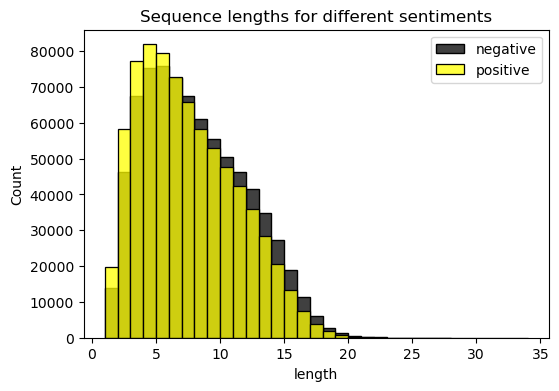

In [109]:
plt.figure(figsize=(6,4))

sns.histplot(x = 'length', data = df[df['target']==0], binwidth=1, color='black')
sns.histplot(x = 'length', data = df[df['target']==1], binwidth=1, color = 'yellow')
plt.title('Sequence lengths for different sentiments')

plt.legend(['negative', 'positive'])


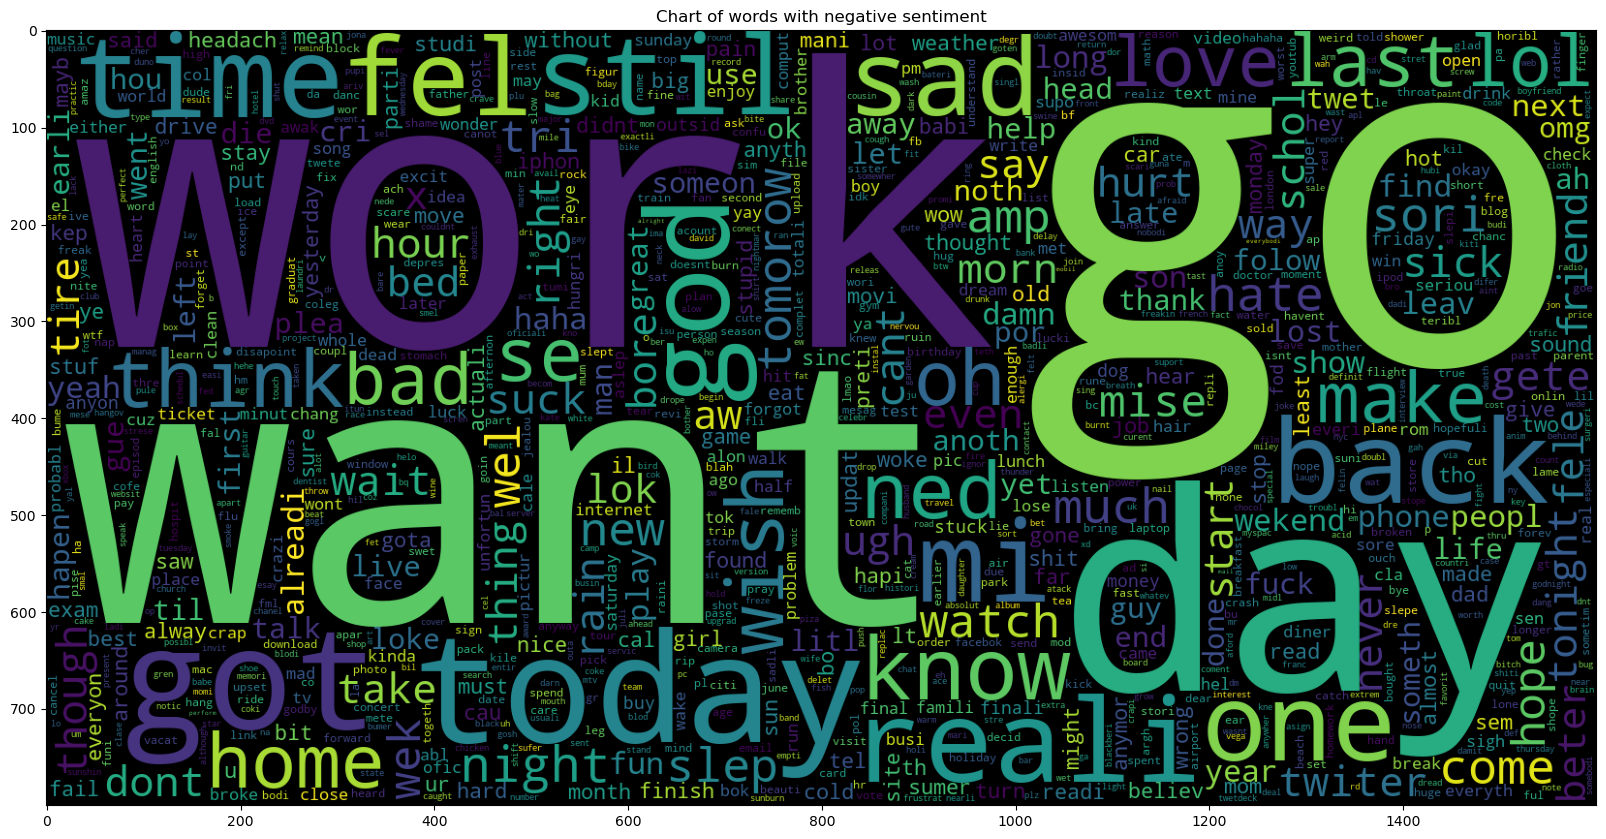

In [110]:
data_neg = df[df['target']==0]['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

plt.title('Chart of words with negative sentiment')
plt.imshow(wc)

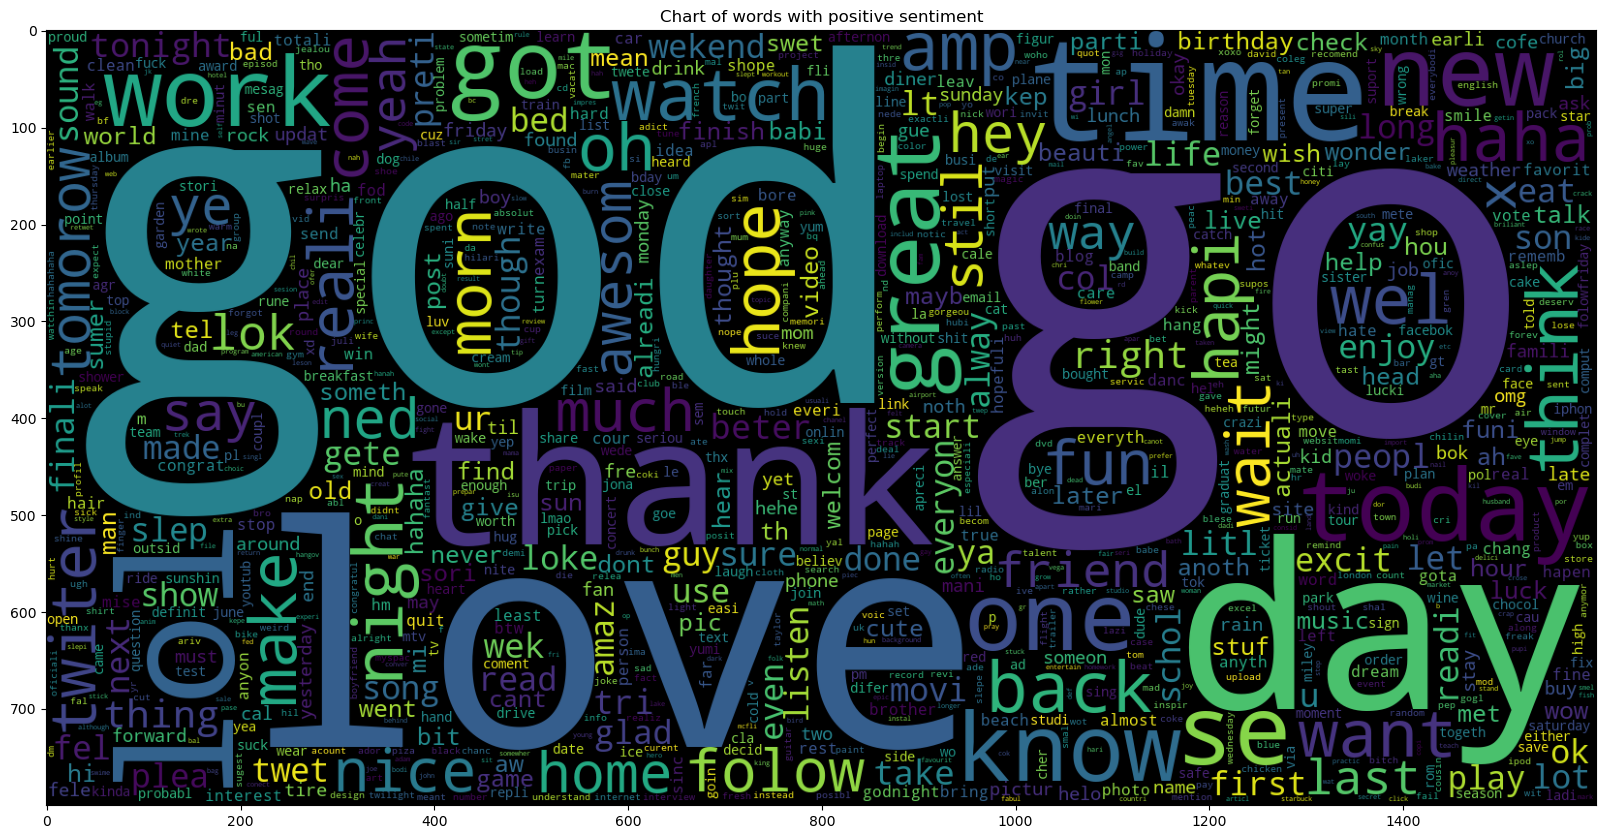

In [111]:
data_pos = df[df['target']==1]['text'].apply(lambda x: ' '.join(x))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))

plt.title('Chart of words with positive sentiment')
plt.imshow(wc)


### Saving the cleaned dataset to twitter.cleaned.csv 

In [112]:
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [113]:
df.drop('length', axis=1).to_csv("twitter.cleaned.csv", index=False)

In [114]:
df

text  target  length
0             love not wait se admin best server ever hapi     1.0       9
1                                              folowfriday     1.0       1
2        recruit comun server sharepoint dev gig austin...     1.0      12
3        not pay god seat watch miley gue bc switch god...     0.0      14
4                   ah excit pushi home okay aw hapi right     1.0       8
...                                                    ...     ...     ...
1548159     go go big hous borow si guitar play mayb write     1.0      10
1548160  dish sen prepar websit would afraid recomend p...     1.0       8
1548161                                           birthday     1.0       1
1548162                            huri not think jon kate     1.0       5
1548163  ltlti not know cud dat phone til wowmi life co...     1.0      11

[1545971 rows x 3 columns]

# 2. Data Modelling 

In [119]:
df

text  target  length
0             love not wait se admin best server ever hapi     1.0       9
1                                              folowfriday     1.0       1
2        recruit comun server sharepoint dev gig austin...     1.0      12
3        not pay god seat watch miley gue bc switch god...     0.0      14
4                   ah excit pushi home okay aw hapi right     1.0       8
...                                                    ...     ...     ...
1548159     go go big hous borow si guitar play mayb write     1.0      10
1548160  dish sen prepar websit would afraid recomend p...     1.0       8
1548161                                           birthday     1.0       1
1548162                            huri not think jon kate     1.0       5
1548163  ltlti not know cud dat phone til wowmi life co...     1.0      11

[1545971 rows x 3 columns]